# Dataset Generation

The project proposes to leverage machine learning (ML) and natural language processing (NLP) techniques to build a text classifier that automatizes the processing and identification of evidence of social impact in research documents. The proposal aims to solve  a classification problem in which the model takes a sentence contained in a research document as input and produces as output a binary answer (1=True, 0=False) that states whether the sentence contains or not evidence of social impact. In this sense, training a machine-learning algorithm to automatically identify evidence of social impact in research documents requires having a dataset with both examples, namely sentences that provide evidence of impact and general sentences.

From all research fields, this project focuses on Medical, Health, and Biological science because the ultimately goal is to understand the social impact of the research projects of the Spanish National Institue of Bioinformatics (INB by its Spanish Acronym), which is an institution that conducts medical and biological investigations.

In the first part of this notebook, I experiment with **sentiment analysis** and **k-means** to see whether they can be useful to automatize at least part of the process of detection of sentences with evidence of social impact. The reason of using Sentiment Analysis is to automatically identify positive sentences, which might contain evidence of social impact since it is expected that evidence of social impact is written in a positive tone. The use of K-means is motivated by the fact that it might be that senteces with evidence of social impact follow similar patterns in the words they use. So, it is expected that they k-means algorithms will be able to identify group sentences with similar patterns. Either in the case of sentiment analysis and k-means, a posterior manual processing will be conducted to validate the result.

Summaries of the societal impact of Medical, Health, and Biological research published by the Research Excellence Framework (REF)---REF is the evaluation system used in the United Kingdom to measure the quality of research of their higher education institutions---will be used to this part of the work.

In the second part of the notebook, the plan is to collect and process general sentences that are commonly available in scientific documents in the field of Health and Biology. Late, the processed sentences will be used to complemente the dataset of evidence of social impact. Here, the dataset of full-text of 29,437 articles of health and biology produced by Ye et al. as part of their publication [SparkText:Biomedical Text Mining on Big Data Framework](https://www.researchgate.net/publication/308759738_SparkText_Biomedical_Text_Mining_on_Big_Data_Framework) will be used.

The goal here is to generate a dataset that include both sentences that contain evidence of social impact of research and sentences that do not contain evidence of social impact.

## Load dependencies

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import re

from nltk.tokenize import sent_tokenize, word_tokenize

In [3]:
project_dir = os.getcwd()
print('Directory of project: {}'.format(project_dir))

Directory of project: /home/jorge/Dropbox/Development/impact-classifier


---
# First Part

## Load data

The data were extracted from the impact case studies published by REF (Research Excellence Framework) and it contains the summary of societal impact of Medical, Health, and Biological research. Summaries can be access [here](https://impact.ref.ac.uk/casestudies/Results.aspx?Type=I&Tag=5085).

In [4]:
data = pd.read_csv('data/social_impact_ref_bio_medicine.csv')

In [5]:
data.head()

,Case Study Id,Institution,Unit of Assessment,Title,Summary of the impact
0,942,\n University of Kent and University of Gre...,"Allied Health Professions, Dentistry, Nursing ...",\n The Guide to Receptors and Channels: a k...,\n The Guide to Receptors and Channels has ...
1,3405,\nCardiff University\n,"Geography, Environmental Studies and Archaeology",\nChanging people's perceptions of the human:a...,\nThe Cardiff Osteological Research Group (COR...
2,15620,\n Royal Veterinary College\n,"Agriculture, Veterinary and Food Science",\n Giant Animals: evolution and biomechanic...,\n Professor Hutchinson's team has pursued ...
3,16710,\n University of Cambridge\n,Physics,\n Mainstreaming Biological Physics in the ...,\n Material has been prepared for the Insti...
4,18226,\n University of Chester\n,"Psychology, Psychiatry and Neuroscience",\n Informing Global Improvements on the Wel...,\n This research programme has provided con...


Special attention will be paid to the column **Summary of the impact**, which is the column of interest here.

In [6]:
print('Data set dimension. Rows: {0}, Columns: {1}'.format(data.shape[0], data.shape[1]))

Data set dimension. Rows: 571, Columns: 5


## Clean and Transform Data

Remove no-ascii characters and split summaries of impact into sentences.

In [7]:
def process_data(text):
    # remove any character except letter, numbers, and percentage sign
    text = re.sub(r"[^a-zA-Z0-9%]", " ", text.lower())
    # remove newlines, tabs, and extra spaces
    text = re.sub(r"\t", " ", text)
    text = re.sub(r"\n", " ", text)
    text = re.sub("  ", " ", text)
    text = re.sub("   ", " ", text)
    text = text.strip()  # remove leading and trailing spaces
    return text

In [8]:
clean_data = pd.DataFrame(columns=['title', 'impact_sentence'])
for i in data.index:
    title = process_data(data.loc[i, 'Title'])
    sentences = sent_tokenize(data.loc[i, 'Summary of the impact'])
    for sentence in sentences:
        clean_data = clean_data.append({'title': title, 'impact_sentence': process_data(sentence)}, 
                                       ignore_index=True)        

In [9]:
clean_data.head()

,title,impact_sentence
0,the guide to receptors and channels a key tool...,the guide to receptors and channels has contri...
1,the guide to receptors and channels a key tool...,the key tools it provides have influenced appr...
2,the guide to receptors and channels a key tool...,it is used widely as a teaching aid for under...
3,the guide to receptors and channels a key tool...,it led to the formation of the guide to pharm...
4,changing people s perceptions of the human ani...,the cardiff osteological research group corg h...


In [21]:
print('Total number of sentences: {0}'.format(clean_data.shape[0]))

Total number of sentences: 2373


## Sentiment Analysis

Sentiment analysis is used to focus the manual processing only on sentences with a positive tone since it is expected that sentences with evidence of social impact are written using a positive attitude.

In [ ]:
# Load the required libraries
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [10]:
analyzer = SentimentIntensityAnalyzer()

In [17]:
def analyze_sentiment(row):
    score = analyzer.polarity_scores(row['impact_sentence'])
    if score['compound'] >= 0.05:
        sentiment = 'positive'
    elif 0.05 > score['compound'] >= -0.05:
        sentiment = 'neutral'
    else:
        sentiment = 'negative'    
    
    return pd.Series([row['title'], row['impact_sentence'], sentiment, score['compound']], 
                     index=['title', 'sentence', 'sentiment', 'score'])    

In [18]:
#todo: remove stopwords before applying sentiment
sa_impact_text = clean_data.apply(analyze_sentiment, axis=1)

In [54]:
sa_impact_text.head(10)

,title,sentence,sentiment,score
0,the guide to receptors and channels a key tool in the maintenance and development of pharmacology,the guide to receptors and channels has contributed to the development and maintenance of the intellectual infrastructure of pharmacology,positive,0.5106
1,the guide to receptors and channels a key tool in the maintenance and development of pharmacology,the key tools it provides have influenced appropriate identification of lead drug targets and how best to study them and as a result it has received endorsement and financial support from the pharmaceutical industry,positive,0.8481
2,the guide to receptors and channels a key tool in the maintenance and development of pharmacology,it is used widely as a teaching aid for undergraduates and research postgraduates and provides the general public with accurate information on prescription drug action,neutral,0.0000
3,the guide to receptors and channels a key tool in the maintenance and development of pharmacology,it led to the formation of the guide to pharmacology website in collaboration with the international union of basic and clinical pharmacology,neutral,0.0000
4,changing people s perceptions of the human animal relationship,the cardiff osteological research group corg has researched the complex relationship between animals and people across britain europe and beyond,neutral,0.0000
5,changing people s perceptions of the human animal relationship,corg has taken its research as the basis for a programme of activities that seeks to challenge modern attitudes to animals through archaeological studies and to provoke reflection on the present relevance and future development of animals,negative,-0.3400
6,changing people s perceptions of the human animal relationship,their impact has built on relationships developed with artists and practitioners in creative industries who have been influenced by the issues researched,positive,0.4404
7,changing people s perceptions of the human animal relationship,by encouraging a range of audiences to consider the economic social ritual and symbolic roles of animals corg has enriched informed and changed the perspectives of individuals who do not normally engage with the archaeological past including target groups traditionally excluded from or not aware of academic research,neutral,-0.0093
8,giant animals evolution and biomechanics inspiring future science,professor hutchinson s team has pursued research into movement of large land animals and how they have evolved under biomechanical constraints such as gravity which dominate their lifestyles,negative,-0.1280
9,giant animals evolution and biomechanics inspiring future science,their findings relating to elephants and to dinosaurs applying physics maths and computer science to study the natural world have captured the public s imagination through a variety of engagement activities,positive,0.6705


In [30]:
dist_sentiments = sa_impact_text['sentiment'].value_counts()
dist_sentiments

positive    1346
neutral      579
negative     448
Name: sentiment, dtype: int64

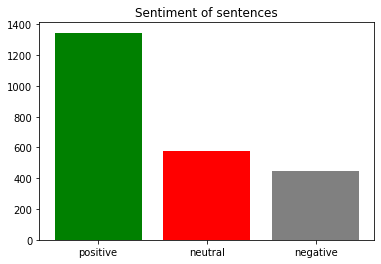

In [31]:
plt.bar(dist_sentiments.index, dist_sentiments, color=['green', 'red', 'gray'])
plt.title('Sentiment of sentences')
plt.show()

### Sanity check

The plan now is to manually random sample of the positive sentences to check whether they contain evidence of social impact. However, before we have to make sure that neutral and negative sentences (false negatives) are correct. So, let's manually inspect a random sample of sentences in the neutral and negative group. We will discard the option of using sentiment analysis to automatically identifies sentences with evidence of social impact if we find more 5% of error in either group, neutral or negative.

In [39]:
# avoid pandas to truncate string columns
pd.set_option('display.max_colwidth', None)

In [53]:
sample_size = 20

In [43]:
sample_negative = sa_impact_text[sa_impact_text['sentiment']=='negative'].sample(n=sample_size, random_state=1)
sample_negative.shape

(50, 4)

In [44]:
sample_negative.head()

,title,sentence,sentiment,score
1026,informing rights based challenges to mainstream policy responses to human trafficking,o connell davidson s pioneering research delivered the first systematic study of the demand for prostitution and domestic work and contested mainstream policy responses to human trafficking childhood and migration,negative,-0.1280
1497,reshaping resilience practices a co production approach,collaborative research with practitioners parents and young people has led to the development of resilient therapy rt a new approach to building resilience in disadvantaged families,negative,-0.4019
1002,the big picture show depictions of truce at the imperial war museum,second a big picture show bps part of the rolling programme at the imperial war museum north iwmn,negative,-0.5994
183,how the development and application of techniques for assessing the payback or impact from health research informs policies to support health research,second many stakeholders made extensive use the findings of payback studies in public debate and private lobbying for public expenditure on health research,negative,-0.0772
1262,bullying cyberbullying and e safety in children and young people the impact of research by the unit for child and youth studies york st john university,research has shown that being a victim of bullying can have serious and long term negative effects on psychological well being hawker amp boulton 2000,negative,-0.8360


In [49]:
sample_negative.to_csv('data/sa_evaluation/sample_negative_sentences.csv')

Sentences in the negative sample were imported in [here](https://docs.google.com/spreadsheets/d/1UFmlKuCEoOB8toKuQUCTWBBL6ZO2RhhLJloomJtaqvY/edit#gid=0). After a manual inspection of the sentences, we found that the sentiment analysis could correctly derive the sentiment of only 12% of the sentences. So, it produced an **error of 0.88**. It seems that the negative term (e.g., disadvantages, abuse, human trafficking, victim, bullying) used to express social situations that has changed because of the research, undermined the correct classification of sentences.

In [38]:
sample_neutral = sa_impact_text[sa_impact_text['sentiment']=='neutral'].sample(n=sample_size, random_state=1)
sample_neutral.shape

(20, 4)

In [46]:
sample_neutral.head()

,title,sentence,sentiment,score
887,empowering french front line hospital nursing managers to deal positively with the pressures of modernisation,vaughan rogers work with ca,neutral,0.0
1767,building a safer surgical workforce driving innovation in simulation training amp educational research,this body of multidisciplinary research brings together imperial s contributions in simulation science skills assessment performance shaping factors educational theory and surgical practice to contribute to national and international healthcare education and policy,neutral,0.0
1515,redesigning tourism policy and practices in africa,in the gambia the research led to the ministry of tourism and culture developing service standards and establishing the 8364 2 7m gambia tourism and hospitability institute,neutral,0.0
1744,human rights and older people,this case study involves the research of professor john williams on the law and older people and its impact on health and welfare practitioners and public policy law and services within the uk and his contribution to an international debate on the need for a un convention on the rights of older people,neutral,0.0
2003,emerging biomedical technologies shaping practices and influencing policy,professor andrew webster s sociological research on developments in biomedical science has been impactful in shaping regulatory practice and influencing policy in relation to biobanking stem cell research and regenerative medicine,neutral,0.0


In [51]:
sample_neutral.to_csv('data/sa_evaluation/sample_neutral_sentences.csv')

Sentences in the negative sample were imported in [here](https://docs.google.com/spreadsheets/d/1UFmlKuCEoOB8toKuQUCTWBBL6ZO2RhhLJloomJtaqvY/edit#gid=1799513637). After a manual inspection of the sentences, we found that the sentiment analysis could correctly derive the sentiment of 45% of the sentences. So, it produced an **error of 0.55**.

Due to the high-errors, we discarded the idea of using sentiment analysis to automoatically identify sentences with evidence of social impact.

---
## K-means

K-means will be used to see whether applying this clustering algorithm can help to distinguish sentences with evidence of impact from sentences without evidence of social impact. The code in this section is an adaptation of the document clustering tutorial presented in the blog post [Document Clustering with Python](http://brandonrose.org/clustering_mobile).

In [69]:
# Import the required libraries
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
from nltk.stem.snowball import SnowballStemmer

import joblib
import nltk

In [204]:
stopwords = nltk.corpus.stopwords.words('english')
stopwords.extend(['research', 'uk'])
stemmer = SnowballStemmer("english")

In [205]:
def tokenize_sentence(sentence, do_stemming=True):
    # tokenize sentence by words
    tokens = word_tokenize(sentence)
    filtered_tokens = []
    # filter out any tokens not containing numbers and letters
    for token in tokens:
        if re.search('[a-zA-Z0-9]', token) and token not in stopwords:
            filtered_tokens.append(token)
    if do_stemming:
        stems = [stemmer.stem(t) for t in filtered_tokens]
        return stems
    else:
        return filtered_tokens

In [206]:
vocabulary_stemmed = []
vocabulary = []
for sentence in list(clean_data['impact_sentence']):
    vocabulary_stemmed.extend(tokenize_sentence(sentence))
    vocabulary.extend(tokenize_sentence(sentence, do_stemming=False))

In [207]:
vocabulary_df = pd.DataFrame({'words': vocabulary}, index = vocabulary_stemmed)
print('There are ' + str(vocabulary_df.shape[0]) + ' items in vocabulary')

There are 41812 items in vocabulary


In [208]:
vocabulary_df.head()

,words
guid,guide
receptor,receptors
channel,channels
contribut,contributed
develop,development


In [209]:
#define vectorizer
tfidf_vectorizer = TfidfVectorizer(max_df=0.7, max_features=500,
                                   min_df=0.03, use_idf=True, tokenizer=tokenize_sentence, 
                                   ngram_range=(1,3))
#fit the vectorizer to sentences
tfidf_matrix = tfidf_vectorizer.fit_transform(list(clean_data['impact_sentence']))

In [210]:
pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names()).head()

,across,activ,also,approach,awar,base,benefit,bodi,care,case,...,understand,univers,use,well,wide,within,work,world,young,young peopl
0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.391007,0.0,0.548067,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
4,0.617766,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0


In [211]:
terms = tfidf_vectorizer.get_feature_names()
print(terms)

['across', 'activ', 'also', 'approach', 'awar', 'base', 'benefit', 'bodi', 'care', 'case', 'case studi', 'centr', 'chang', 'child', 'children', 'communiti', 'contribut', 'countri', 'debat', 'demonstr', 'design', 'develop', 'direct', 'educ', 'effect', 'engag', 'enhanc', 'evalu', 'evid', 'famili', 'find', 'first', 'focus', 'govern', 'group', 'guidelin', 'health', 'help', 'impact', 'improv', 'includ', 'increas', 'influenc', 'inform', 'intern', 'intervent', 'issu', 'key', 'lead', 'led', 'level', 'local', 'major', 'manag', 'media', 'nation', 'need', 'new', 'organis', 'patient', 'peopl', 'perform', 'polici', 'practic', 'practition', 'profession', 'professor', 'programm', 'project', 'provid', 'public', 'relat', 'result', 'school', 'servic', 'signific', 'social', 'sport', 'studi', 'support', 'train', 'understand', 'univers', 'use', 'well', 'wide', 'within', 'work', 'world', 'young', 'young peopl']


In [266]:
num_clusters = 3 # tried different values from 2 to 6 and 3 seems to be best option
km_model = KMeans(n_clusters=num_clusters)
km_model.fit(tfidf_matrix)
clusters = km_model.labels_.tolist()

In [267]:
sentences = {'sentence': list(clean_data['impact_sentence']), 'cluster': clusters}
clusters_df = pd.DataFrame(sentences, index = [clusters] , columns = ['sentence'])

In [268]:
clusters_df.head()

,sentence
0,the guide to receptors and channels has contributed to the development and maintenance of the intellectual infrastructure of pharmacology
0,the key tools it provides have influenced appropriate identification of lead drug targets and how best to study them and as a result it has received endorsement and financial support from the pharmaceutical industry
0,it is used widely as a teaching aid for undergraduates and research postgraduates and provides the general public with accurate information on prescription drug action
2,it led to the formation of the guide to pharmacology website in collaboration with the international union of basic and clinical pharmacology
0,the cardiff osteological research group corg has researched the complex relationship between animals and people across britain europe and beyond


In [269]:
print("Top terms per cluster:")
print()
#sort cluster centers by proximity to centroid
order_centroids = km_model.cluster_centers_.argsort()[:, ::-1] 
words_per_cluster = 6
for i in range(num_clusters):
    print("Cluster %d words:" % i, end='')    
    for ind in order_centroids[i, :words_per_cluster]:
        print(' %s' % vocabulary_df.loc[terms[ind].split(' ')].values.tolist()[0][0], end=',')
    print() #add whitespace
    print() #add whitespace

Top terms per cluster:

Cluster 0 words: development, impact, used, public, work, people,

Cluster 1 words: health, care, public, social, services, impact,

Cluster 2 words: policy, international, national, governments, practical, changed,



In [270]:
for i in range(0, num_clusters):
    print('Number of sentences in Cluster {0}: {1}'.format(i, len(clusters_df.loc[i])))
    print()

Number of sentences in Cluster 0: 1582

Number of sentences in Cluster 1: 286

Number of sentences in Cluster 2: 505



### Sanity check

Let's check some examples of sentences in each group to see whether there is a group that contains only sentence with (or without) evidence of social impact.

In [216]:
sample_size=20

#### Cluster 0

In [271]:
sample_cluster0 = clusters_df.loc[0].sample(n=sample_size, random_state=1)
sample_cluster0

,sentence
0,we have also trained over 1300 professionals to deliver mbct within the nhs and other contexts leading to several successful spin off businesses
0,key beneficiaries have been community organisations whose skills have been enhanced to use research evidence in identifying user requirements successfully securing funding and meeting user needs
0,professor richard berthoud has addressed the issues by exploring the interaction between disabled people s impairments and employers expectations
0,this research has helped the equality and human rights commission ehrc to fulfil its statutory role to promote equality and human rights
0,these impacts have reached far beyond the uk extending to ireland central and eastern europe australia and elsewhere
0,as a direct result of research conducted by professor bencie woll at the deafness cognition and language research centre dcal ucl the nhs has established the first neuropsychology clinic for deaf patients who use british sign language within the cognitive disorders clinic at the national hospital for neurology and neurosurgery nhnn
0,findings of the project led to the hlp concept being rolled out across england in 2012 to 20 pathfinder sites areas regions site sounds like an individual pharmacy involving 100 pharmacies
0,jones has engaged in theological and philosophical research in bioethics at st mary s university college smuc since 2002
0,since the end of march 2006 smoking has been prohibited by law in all enclosed public spaces throughout scotland with the specific aim of protecting non smokers from the effects of second hand smoke
0,using an innovative platform to target the delivery of complex biomedical science to young people the zombie science comedy show has effectively engaged more than 26 000 young people and adults at more than 300 events touring festivals and secondary schools around the uk


#### Cluster 1

In [272]:
sample_cluster1 = clusters_df.loc[1].sample(n=sample_size, random_state=1)
sample_cluster1

,sentence
1,the critical success of his monograph decolonizing international health and its positive reception among non academic specialists in the field led to his involvement in dialogues with policymakers in international ngos and invitations to contribute a historical perspective to discussions about public health issues in the developing world
1,the state of the art electronic rostering programme improves use of resources reduces reliance on costly agency staff reduces the risk of fines for breaching legal requirements such as the european working time directive and leads to significant savings in the health and social care sectors
1,these are based on oxford findings that revealed major effects of parental aids on children s psychological educational and sexual health
1,in addition the research has informed coaches ice hockey and rugby union and people working in the fitness industry personnel trainers and has contributed to the debate on exercise for health scottish government
1,the research has had practical applications in foot health and welfare of elephants in captivity and through examining constraints of growth on anatomy has also led to applications in health of broiler chickens
1,our research has had substantial impact on the mental health and welfare of children with suspected autistic disorders on their education on the well being of their families and on the activities of healthcare professionals and their services for children in both paediatric and psychiatric practice
1,through work with the departments of health and education in northern ireland ni and ireland irl our research led to the introduction of an educational resource into the national curricula of post primary schools in irl and ni
1,the ioe s evidence for policy and practice information and co ordinating eppi centre has helped uk and overseas governments to make better informed decisions on education public health and health education social welfare and international development through the use of systematic reviews
1,second many stakeholders made extensive use the findings of payback studies in public debate and private lobbying for public expenditure on health research
1,policymakers in the government departments responsible for health and education local safeguarding children boards lscbs and many thousands of professionals with child protection roles have benefited from bristol s research into inter agency training


#### Cluster 2

In [273]:
sample_cluster2 = clusters_df.loc[2].sample(n=sample_size, random_state=1)
sample_cluster2

,sentence
2,the findings of university of reading research around the contemporary proliferation of regulatory myths and media misrepresentation of health and safety law have been used by a number of stakeholder organisations and charitable bodies in evidence given to official government reviews and drawn upon by those reviews as part of the development of policy recommendations for government
2,it has also informed service and policy developments in the united kingdom and internationally
2,furthermore the research has influenced international public food policies such as those of the united nations
2,there has been impact at national and local government level driving changes in policy and practice
2,child protection policy and practice has largely ignored young people s experiences of child sexual exploitation cse and peer on peer violence
2,jacqueline barnes evaluations of government initiatives promoting parenting and child development for vulnerable families have directly affected major policy decisions since 2008
2,the worst of institutional child care came to the attention of the public and policy makers in the 1990s following the fall of ceau 351 escu in 1989 when pictures of children in romanian orphanages were broadcast around europe and america
2,the case described shows that work reported in the 2008 rae exploring the information seeking strategies of older users is currently having a direct and significant impact on government policy in respect of the broad area of digital inclusion
2,the main beneficiaries of this research are liverpool city council the national union of students nus and the student population within merseyside
2,anna lawson s research into disability equality and human rights has shaped and strengthened the disability policy of the european union eu and council of europe coe


In contrast to sentiment analysis, K-means shows to be useful in grouping together sentences with similar topics. **`Cluster 0`** contains a mix of sentences with evidence of social impact with more general phrases. **`Cluster 1`** has sentences that show how the research has impacted in medical practices while **`cluster 2`** includes sentences that tells how the research informed public policies. Next, the plan is to export the sentences and their clusters to a CSV file. Then, with the help of Google Spreadsheet, go manually through sentences in the clusters and label them to indicate whether they contain evidence of impact or not.

In [274]:
# save sentences and clusters into a CSV file
clusters_df.to_csv('data/k_means/clusters.csv')

A sample of sentences in each cluster were manually processed to identify those that contain evidence of social impact. In total, 1037 sentences were annonated. In particular, 511, 263, and 263 sentences from **`Cluster 0`**, **`Cluster 1`**, and **`Cluster 2`**, respectively, were labeled with 1 if the sentence contains evidence of social impact while with 0 otherwise. The annotation process was valided through a cross-checking procedure; a second annotator was asked to label a random sample of 200 annotated sentences. The level of agreement between the two annotators was 86%. Out of the 1037 annotated sentences, 197 were found to contain evidence of social impact. The following [Google Spreadsheet](https://docs.google.com/spreadsheets/d/1A-8W4ajP1vSJSvciajxvPg3phga9BKUTVhHi_wDuy9o/edit?usp=sharing) was used to conduct the annotation and validation process.

---
# Second Part

In this part of the notebook, the dataset of full-text of 29,437 articles of health and biology produced by Ye et al. as part of their publication [SparkText:Biomedical Text Mining on Big Data Framework](https://www.researchgate.net/publication/308759738_SparkText_Biomedical_Text_Mining_on_Big_Data_Framework) is used. Every row in the dataset represents the full-text of an article.

## Load data

Let's load the dataset. I am using the default CSV library of Python because instead of Pandas because in this case I do not need a full dataframe but only a list of strings, which will represent the articles.

In [32]:
import csv
texts = []
with open('data/SparkText_SampleDataset_29437Fulltexts.csv', encoding='utf-8', errors='ignore') as csvfile:
    reader = csv.DictReader(csvfile, fieldnames=['code','text'], delimiter= ' ')
    for row in reader:
        if row['text'] == 'text': # header
            continue
        texts.append(row['text'])

### Sample

In [36]:
texts[0]

'In this case, apoptosis-deficient Becn1+/+ iMMECs stably expressing ERBB2 under low (1%) oxygen and glucose-deprivation conditions showed decreased number of autophagosomes compared with their non-ERBB2-expressing Becn1+/+ counterparts (Fig. 2F and G). Interestingly, the level of autophagy induction in metabolically stressed ERBB2-expressing Becn1+/+ iMMECs was similar to that of vector-expressing Becn1+/? iMMECs (Fig. 2F and G), confirming that ERBB2 overexpression renders mammary epithelial cells partially autophagy-deficient under stress. To further investigate the impact of ERBB2 overexpression on stress-induced autophagy in an alternate system and in an apoptosis-competent background, we used a transient ERBB2 expression system.40 To this intent, Becn1+/+ iMMECs stably overexpressing EGFP-LC3B were transiently transfected with a ERBB2-expressing or vector control plasmid and, after overnight recovery in regular culture medium, were incubated in Hanks medium for up to 3.5 h. Simil

## Split text in sentences

In [37]:
general_sentences = [sentence for text in texts for sentence in sent_tokenize(text)]

In [40]:
print('There are {0:,} sentences contained in the 29,437 articles in the dataset.'.format(len(general_sentences)))

There are 2,318,588 sentences contained in the 29,437 articles in the dataset.


## Sentences selection

Now, I will randomly select 800 sentences to complement the sentences that contain evidence of social impact. The number 800 was choosen to have in total 1,000 sentences in the combined dataset that will be used train and test the machine learning model. More than 800 sentences can be selected but this will increase the unbalance in dataset. **The big assumption here is that the selection is composed of general sentences that do not contain evidence of social impact**.

In [44]:
# generate a list of 800 random numbers between 0 and 2,318,588
total_sentences = 800
random_idxs = np.random.randint(low=0, high=len(general_sentences), size=total_sentences)

In [46]:
selected_gral_sentences = [general_sentences[idx] for idx in random_idxs]

### Sanity check

In [50]:
print('Out of the {0:,} sentences {1:,} of them were selected'.format(len(general_sentences), len(selected_gral_sentences)))

Out of the 2,318,588 sentences 800 of them were selected


### Sample

In [51]:
selected_gral_sentences[50]

'This is an interesting result, given that to date only one SNP, rs4691139 in the 4q35.3 region, also identified through the iCOGS effort, has been found to modify ovarian cancer risk specifically in BRCA1 carriers [32].'

## Normalization